# Time Series Forcasting and Analysis: the Zillow Dataset
In this project, I work with a dataset from <a href='http://www.zillow.com'>Zillow</a> that has house prices over the course of several month-years, starting in 1996. The dataset also provides other information such as: zip code, region, county name and city - to name a few. I analyze these series using a time series approach and provide recommendations for an hypothetical real estate firm.

I start by introducing the business problem, then following the usual time series workflow. A brief analysis of the dataset is performed before delving into the modeling features.

The modeling framework is streamlined as follows: time series analysis, basic and rolling statistics, seasonal decomposition, unit-root test, SARIMAX modeling and prediction. Lastly, we delve deeper into the data, repeating this process with microscopic lenses.

### Business Problem
The (hypothetical) firm Goodeye Investors LLC is looking to diversify its portfolio. The company feels inflation is creeping up and would like to invest in real assets, such as houses. At the same time, interest rates are going up so liquidity is constrained. Thinking of risk-weighted returns, then the firm seeks advisory for spotting the best areas over the course of 12-24 months.

The stakeholders of this problem, besides the investment firm, are: general public and outside investors, municipalities and counties and communities in general.

## Basic Libraries and Functions
I start by importing the libraries that are going to be used. After that, I build a set of functions that will execute tasks on the DataFrames that are going to be analyzed. The aim of these functions is to streamline the procedures that are going to be performed on the dataset.

In [1]:
# Importing the libraries
import folium
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Setting up display format
pd.options.display.float_format = "{:,.2f}".format

# Convergence warnings supression
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)



In [40]:
# Defining modeling functions

# Flattening and Grouping the DataFrame
def flat_df(df, name, state, id_vars = ('CountyName', 'State'), cols = '1996-04'):
    
    '''Takes a dataframe, the county name, and state as inputs - using a default date of 1996-04.
    The function flattens out the DataFrame with respect to the inputs above, and turns it into long format.
    '''
    
    flat = pd.melt(df, id_vars = id_vars, value_vars = df[cols], var_name = 'Date', value_name = 'Actual Data')
    flat['Date'] = pd.to_datetime(flat['Date'], format = '%Y-%m')
    flat = flat.set_index('Date')
    flat = flat.loc[(flat['CountyName'] == name) & (flat['State'] == state)]
    group_df = flat.groupby(['Date']).median()
    return group_df


# Time Series Train-Test Split - using a 75-25% rule
def ts_train_test(df):
    
    '''Time Series train-test split, using a 75-25% rule. Takes a dataframe as input.'''
    
    size = int(round(len(df)*.25, 0))
    train = df[:-size].asfreq('MS')
    test = df[-size:].asfreq('MS')
    return train, test

# Defining a function for ACF and PACF plots - inspired by Flatiron School's Time Series Lab
def func_plot(dataframe):
    
    '''This function will plot the autocorrelation and partial autocorrelation plots from a DataFrame.'''
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
    plot_acf(dataframe, ax = ax1, lags = 12)
    plot_pacf(dataframe, ax = ax2, lags = 12)
    plt.show()
    
# Seasonal Decomposition - inspired by Flatiron School's 
# https://github.com/flatiron-school/ds-time_series_modeling_walkthrough-gfc33
def seas_dec(df):
    
    '''Takes a dataframe as input, then tests the combination of pdq and pdqs' that \
    yields the lowest AIC through the SARIMAX model. Due computational limitations, I only set it up to 2 runs.
    '''
    
    p = d = q = range(0,3)
    train = ts_train_test(df)[0]
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
   
    aic_dict = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod=SARIMAX(train,
                             order=param,
                             seasonal_order=param_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
                results = mod.fit()
                aic_dict[str(param) + 'x' + str(param_seasonal)] = round(results.aic,4)
            except: 
                continue
    aic_list = sorted(aic_dict.items(), key = lambda x: x[1])[0]
    return print('The combination of', aic_list[0], 'yields the AIC of', aic_list[1])
    

# Root-Mean Squared Error calculation with output and graphs
def rmse_calc(df, pdq = (0,0,0), pdqs = (0,0,0,0), train_test = 'train', window = 24):
    
    '''This function calculates the Root-Mean Squared Error for train (default) or \
    testing data, taking as input the dataframe, the pdq and pdqs factors (order and seasonal order) \
    an argument (i.e whether 'test' or 'train') and a default window of 24 months. Its outputs are \
    the summary diagnostic for the SARIMAX model, with plots and the RMSE.
    '''
    
    train, test = ts_train_test(df) 
    
    # If 'train' or else
    if train_test == 'train':
        model = SARIMAX(train, order = pdq, seasonal_order = pdqs)
        output = model.fit()
        y_hat = output.predict(-window)
        mse = round(np.sqrt(mean_squared_error(train[-window:], y_hat)), 4)
        print(output.summary())
        output.plot_diagnostics(figsize = (10,5))
        plt.tight_layout()
        plt.figure(figsize = (10, 5))
        plt.plot(train[-2 * window:], label = 'Training Data')
        plt.title('Training Data and Predicted Data')
        plt.plot(y_hat, label = 'Predicted Data')
        plt.legend()
        plt.show()
    else:
        model = SARIMAX(test, order = pdq, seasonal_order = pdqs)
        output = model.fit()
        y_hat = output.predict(-window)
        mse = round(np.sqrt(mean_squared_error(test[-window:], y_hat)), 4)
        print(output.summary())
        output.plot_diagnostics(figsize = (10,5))
        plt.tight_layout()
        plt.figure(figsize = (10, 5))
        plt.plot(test, label = 'Test Data')
        plt.title('Testing Data and Forecasted Data')
        plt.plot(y_hat, label = 'Predicted Data')
        plt.legend()
        plt.show();
        
    print(f'RMSE: {mse}')
    return mse

# Function adapted from
# https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/
def forecast_func(df, pdq = (0,0,0), pdqs = (0,0,0,0), window = 24):
    
    '''This function takes as input a dataframe, and the order and seasonal order factors with a 24-month \
    forecasting window and run it through a SARIMAX model. The output is a plot showing the general shape
    of the forecasted values with respect to the series being used.'''
    
    model = SARIMAX(df, order = pdq, seasonal_order = pdqs)
    output = model.fit()
    
    # Getting fitted values
    fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = window, freq = 'MS')
    fc = pd.DataFrame(index = fc[1:], columns = df.columns)
    aux_df = pd.concat([df, fc])
    aux_df['Forecast'] = output.predict(start = df.index[-1], end = aux_df.index[-1], dynamic = True)
     
    # Plotting
    aux_df.plot(figsize = (15, 8));
    plt.title(f'Forecasting {window} periods')



# Forecasting with confidence intervals - 60-month window
# From https://stackoverflow.com/questions/72808256/plotting-confidence-interval-in-sarimax-prediction-data
def forecast_ci(df, pdq = (0,0,0), pdqs = (0,0,0,0)):
    
    '''This function takes as input a dataframe, and the order and seasonal order factors and retrieves \
    the mean predicted values for a 60-month horizon with confidence intervals around 0.1-0.9.
    '''
    
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    output = model.fit()
    pred = output.get_prediction(start = df.index[-1], end = df.index[-1] + pd.DateOffset(months = 60), 
                                 dynamic = True).summary_frame(alpha = 0.1)
    fig, ax = plt.subplots(figsize = (15, 8))
    pred['mean'].plot(ax = ax, label = 'Forecasted Value')
    ax.fill_between(pred.index, pred['mean_ci_lower'], pred['mean_ci_upper'],
                        color ='r', alpha = .2, label = 'Confidence Interval')
    plt.title('Forecast of Mean Prices')
    plt.xlabel('Date')
    plt.legend()
    plt.show()
    



## Exploratory Data Analysis (EDA)
The project starts with importing our data to a dataframe and inspecting the first rows. The dataset is set up in wide format and also provides other information besides prices. There are: RegionID, RegionName, City, State, Metro, CountyName and SizeRank.

We can see that there is an overlap between RegionName, City, Metro and CountyName. More precisely, the sample has New York, Washington, Los Angeles and other appearing at different positions of the top 5 rankings. Focusing on the more aggregate approach, I will delve deeper into County first and calculate their basic statistic.

In [3]:
# Importing the Zillow dataset
data = pd.read_csv('csv/zillow_data.csv')

# Retrieve the first 5 rows
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00",...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"235,700.00","236,900.00","236,700.00",...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,"210,400.00","212,200.00","212,200.00",...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,"498,100.00","500,900.00","503,100.00",...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"77,300.00","77,300.00","77,300.00",...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
# Dropping NAs
data = data.dropna()

# Columns to Remove when performing calculations
cat_col = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

# We will use this to filter the date columns later on
data_col = list(data.columns)

# Removing Categorical Variables
for col in cat_col:
     data_col.remove(col)


After cleaning the data and setting up some filters that will be used later on, such as data col - that will be used to transform our dataset to long format and perform calculations.

It seems that at the start of the dataset, there isn't much variation with respect to mean, median or standard deviation values. The distribution seems fairly behaved from a high level standpoint, that is, no apparent serious skewness. It is worth noting that as time passes by, the standard deviation increases considerably.

This might yield the idea that prices didn't vary much towards the start of our sampling period, i.e. the market wasn't that vibrant.

In [5]:
# Retrieving Top 5 Metro areas
data['Metro'].value_counts(ascending = False, normalize = True)[:5]


New York                         0.06
Los Angeles-Long Beach-Anaheim   0.03
Chicago                          0.02
Philadelphia                     0.02
Washington                       0.02
Name: Metro, dtype: float64

In [6]:
# Retrieving Top 5 Cities
data['City'].value_counts(ascending = False, normalize = True)[:5]

New York      0.01
Los Angeles   0.01
Houston       0.01
San Antonio   0.00
Washington    0.00
Name: City, dtype: float64

In [7]:
# Retrieving Top 5 County
data['CountyName'].value_counts(ascending = False, normalize = True)[:5]

Los Angeles   0.02
Jefferson     0.01
Orange        0.01
Washington    0.01
Montgomery    0.01
Name: CountyName, dtype: float64

In [8]:
# Describing our Dataset, without the categorical features
data[data_col].describe()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,"12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00",...,"12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00"
mean,"121,203.58","121,327.06","121,449.02","121,568.36","121,699.39","121,851.42","122,050.20","122,281.55","122,631.00","123,078.83",...,"286,636.68","288,292.95","290,050.15","291,772.68","293,396.42","295,114.26","296,821.83","298,687.96","301,031.61","302,709.84"
std,"87,295.61","87,453.86","87,612.46","87,776.32","87,965.17","88,193.06","88,480.98","88,818.47","89,262.76","89,771.67",...,"310,175.26","312,378.06","314,942.48","317,665.58","320,034.99","322,583.32","325,328.07","327,981.37","330,770.19","332,485.34"
min,"11,400.00","11,500.00","11,600.00","11,800.00","11,800.00","12,000.00","12,100.00","12,200.00","12,300.00","12,500.00",...,"14,400.00","14,500.00","14,700.00","14,800.00","14,500.00","14,300.00","14,100.00","13,900.00","13,800.00","13,800.00"
25%,"71,200.00","71,400.00","71,600.00","71,700.00","71,800.00","71,900.00","72,100.00","72,300.00","72,500.00","72,900.00",...,"135,800.00","136,600.00","137,400.00","138,150.00","138,650.00","139,200.00","139,700.00","140,100.00","141,000.00","141,800.00"
50%,"102,200.00","102,300.00","102,300.00","102,400.00","102,500.00","102,500.00","102,700.00","102,900.00","103,100.00","103,500.00",...,"201,200.00","202,500.00","203,700.00","205,200.00","206,400.00","207,600.00","208,500.00","209,800.00","211,500.00","213,000.00"
75%,"145,800.00","145,900.00","146,000.00","146,100.00","146,100.00","146,300.00","146,300.00","146,600.00","147,100.00","147,600.00",...,"325,100.00","326,600.00","328,200.00","330,050.00","331,750.00","333,800.00","335,700.00","337,700.00","340,550.00","342,200.00"
max,"3,676,700.00","3,704,200.00","3,729,600.00","3,754,600.00","3,781,800.00","3,813,500.00","3,849,600.00","3,888,900.00","3,928,800.00","3,964,600.00",...,"7,410,100.00","7,422,400.00","7,417,600.00","7,427,300.00","7,371,400.00","7,342,700.00","7,353,300.00","7,350,300.00","7,363,000.00","7,386,600.00"


### County-State Analysis
After we've seen the general composition of our dataset, I start calculating the historical mean, median and standard deviation. These will be used to rank among locations with respect to these statistics. For the sake of space, I have limited this analysis to only the first top 10 entries.

Irrespective of the metric that is being used, as delineated from previous analysis, we see the usual suspects such as New York into our sample, but also some counties from California and Florida. The difference between New York's statistics with the other selected counties are quite considerable. To wit, NY's median/average/std. deviation are `$5,190,800` / `$5,085,436` / `$1,470,204`; Los Angeles has statistics of `$2,598,900` / `$2,789,977` / `$1,222,910`.

In [9]:
# Calculating historical median, average and std. deviation
data['median'] = data[data_col].median(axis = 1)
data['average'] = data[data_col].mean(axis = 1)
data['std'] = data[data_col].std(axis = 1)

In [10]:
# Top Median CountyNames
med_county = data.groupby(['CountyName', 'State']).max('median').sort_values('median', ascending = False).reset_index()[:10]
med_county

,CountyName,State,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,median,average,std
0,New York,NY,62009,11106,1066,"3,676,700.00","3,704,200.00","3,729,600.00","3,754,600.00","3,781,800.00",...,7427300,7371400,7342700,7353300,7350300,7363000,7386600,"5,190,800.00","5,085,435.85","1,470,203.86"
1,San Mateo,CA,97704,94404,12605,"1,179,200.00","1,184,300.00","1,189,700.00","1,195,400.00","1,201,200.00",...,6315400,6429100,6581800,6705000,6764600,6788400,6796500,"3,506,200.00","3,487,129.06","1,296,223.81"
2,Pitkin,CO,93846,81654,14137,"1,458,200.00","1,453,700.00","1,464,300.00","1,475,000.00","1,485,800.00",...,4193900,4244400,4321700,4381800,4469700,4626100,4766600,"3,268,700.00","3,147,124.15","895,536.33"
3,Palm Beach,FL,399574,33498,8902,"958,400.00","958,100.00","957,900.00","957,800.00","958,000.00",...,4583200,4588200,4609000,4626500,4661200,4692300,4686200,"2,682,500.00","2,634,498.11","1,007,004.81"
4,Los Angeles,CA,399675,93552,14673,"1,015,400.00","1,016,900.00","1,018,400.00","1,019,800.00","1,021,400.00",...,5503000,5574100,5661000,5738200,5816100,5907800,5956700,"2,598,900.00","2,789,977.36","1,222,910.25"
5,San Francisco,CA,97588,94134,5798,"849,100.00","859,000.00","868,800.00","878,400.00","887,800.00",...,4598200,4596300,4579000,4582000,4597600,4640200,4682300,"2,551,500.00","2,630,977.36","987,297.73"
6,Bergen,NJ,60754,7677,13901,"1,075,400.00","1,075,900.00","1,076,500.00","1,077,100.00","1,077,700.00",...,3092700,3077500,3047100,3054800,3061200,3060700,3069100,"2,282,900.00","2,080,074.34","620,753.09"
7,San Diego,CA,96707,92173,13886,"991,000.00","994,700.00","998,400.00","1,002,300.00","1,006,200.00",...,2861500,2864900,2868600,2882000,2893300,2886800,2870800,"2,199,900.00","2,170,121.89","543,539.13"
8,Orange,CA,97079,92887,13835,"706,900.00","710,700.00","714,700.00","718,700.00","723,100.00",...,3305800,3319500,3342300,3367000,3380800,3387400,3393400,"2,129,600.00","2,070,006.04","751,164.50"
9,Suffolk,NY,62324,11980,14536,"455,000.00","454,200.00","453,400.00","452,700.00","452,200.00",...,3298600,3315100,3317200,3353000,3425000,3473300,3467800,"2,107,300.00","1,803,404.15","794,463.61"


In [11]:
# Top Average CountyNames
avg_county = data.groupby(['CountyName', 'State']).max('average').sort_values('average', ascending = False).reset_index()[:10]
avg_county

,CountyName,State,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,median,average,std
0,New York,NY,62009,11106,1066,"3,676,700.00","3,704,200.00","3,729,600.00","3,754,600.00","3,781,800.00",...,7427300,7371400,7342700,7353300,7350300,7363000,7386600,"5,190,800.00","5,085,435.85","1,470,203.86"
1,San Mateo,CA,97704,94404,12605,"1,179,200.00","1,184,300.00","1,189,700.00","1,195,400.00","1,201,200.00",...,6315400,6429100,6581800,6705000,6764600,6788400,6796500,"3,506,200.00","3,487,129.06","1,296,223.81"
2,Pitkin,CO,93846,81654,14137,"1,458,200.00","1,453,700.00","1,464,300.00","1,475,000.00","1,485,800.00",...,4193900,4244400,4321700,4381800,4469700,4626100,4766600,"3,268,700.00","3,147,124.15","895,536.33"
3,Los Angeles,CA,399675,93552,14673,"1,015,400.00","1,016,900.00","1,018,400.00","1,019,800.00","1,021,400.00",...,5503000,5574100,5661000,5738200,5816100,5907800,5956700,"2,598,900.00","2,789,977.36","1,222,910.25"
4,Palm Beach,FL,399574,33498,8902,"958,400.00","958,100.00","957,900.00","957,800.00","958,000.00",...,4583200,4588200,4609000,4626500,4661200,4692300,4686200,"2,682,500.00","2,634,498.11","1,007,004.81"
5,San Francisco,CA,97588,94134,5798,"849,100.00","859,000.00","868,800.00","878,400.00","887,800.00",...,4598200,4596300,4579000,4582000,4597600,4640200,4682300,"2,551,500.00","2,630,977.36","987,297.73"
6,San Diego,CA,96707,92173,13886,"991,000.00","994,700.00","998,400.00","1,002,300.00","1,006,200.00",...,2861500,2864900,2868600,2882000,2893300,2886800,2870800,"2,199,900.00","2,170,121.89","543,539.13"
7,Santa Clara,CA,98011,95148,10656,"795,600.00","798,400.00","801,700.00","805,400.00","809,600.00",...,4401100,4481700,4544700,4595100,4668700,4762600,4818400,"1,890,300.00","2,084,380.38","974,592.78"
8,Bergen,NJ,60754,7677,13901,"1,075,400.00","1,075,900.00","1,076,500.00","1,077,100.00","1,077,700.00",...,3092700,3077500,3047100,3054800,3061200,3060700,3069100,"2,282,900.00","2,080,074.34","620,753.09"
9,Orange,CA,97079,92887,13835,"706,900.00","710,700.00","714,700.00","718,700.00","723,100.00",...,3305800,3319500,3342300,3367000,3380800,3387400,3393400,"2,129,600.00","2,070,006.04","751,164.50"


In [12]:
# Top 10 Std Counties
std_county = data.groupby(['CountyName', 'State']).max('std').sort_values('std', ascending = False).reset_index()[:10]
std_county

,CountyName,State,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,median,average,std
0,New York,NY,62009,11106,1066,"3,676,700.00","3,704,200.00","3,729,600.00","3,754,600.00","3,781,800.00",...,7427300,7371400,7342700,7353300,7350300,7363000,7386600,"5,190,800.00","5,085,435.85","1,470,203.86"
1,San Mateo,CA,97704,94404,12605,"1,179,200.00","1,184,300.00","1,189,700.00","1,195,400.00","1,201,200.00",...,6315400,6429100,6581800,6705000,6764600,6788400,6796500,"3,506,200.00","3,487,129.06","1,296,223.81"
2,Los Angeles,CA,399675,93552,14673,"1,015,400.00","1,016,900.00","1,018,400.00","1,019,800.00","1,021,400.00",...,5503000,5574100,5661000,5738200,5816100,5907800,5956700,"2,598,900.00","2,789,977.36","1,222,910.25"
3,Palm Beach,FL,399574,33498,8902,"958,400.00","958,100.00","957,900.00","957,800.00","958,000.00",...,4583200,4588200,4609000,4626500,4661200,4692300,4686200,"2,682,500.00","2,634,498.11","1,007,004.81"
4,San Francisco,CA,97588,94134,5798,"849,100.00","859,000.00","868,800.00","878,400.00","887,800.00",...,4598200,4596300,4579000,4582000,4597600,4640200,4682300,"2,551,500.00","2,630,977.36","987,297.73"
5,Santa Clara,CA,98011,95148,10656,"795,600.00","798,400.00","801,700.00","805,400.00","809,600.00",...,4401100,4481700,4544700,4595100,4668700,4762600,4818400,"1,890,300.00","2,084,380.38","974,592.78"
6,Pitkin,CO,93846,81654,14137,"1,458,200.00","1,453,700.00","1,464,300.00","1,475,000.00","1,485,800.00",...,4193900,4244400,4321700,4381800,4469700,4626100,4766600,"3,268,700.00","3,147,124.15","895,536.33"
7,Suffolk,NY,62324,11980,14536,"455,000.00","454,200.00","453,400.00","452,700.00","452,200.00",...,3298600,3315100,3317200,3353000,3425000,3473300,3467800,"2,107,300.00","1,803,404.15","794,463.61"
8,Orange,CA,97079,92887,13835,"706,900.00","710,700.00","714,700.00","718,700.00","723,100.00",...,3305800,3319500,3342300,3367000,3380800,3387400,3393400,"2,129,600.00","2,070,006.04","751,164.50"
9,Miami-Dade,FL,72497,33196,10767,"602,700.00","603,600.00","604,600.00","605,800.00","607,200.00",...,3017700,3006400,2999800,3011100,2993200,2933600,2914100,"1,502,900.00","1,611,726.79","732,706.97"


### Plots and Visualization
Next I provide some visual inspection of these top 10 counties so we can inspect their time series behavior. Clearly, we can see an increasing trend over time, with a marked drop after 2008 (except for New York). This is precisely when the mortgage crisis hit the US, so it is consistent with the idea of hoouse prices tumbling. After that period, we still see some variation, but overall prices only went up.

The behavior from New York can be explained as well, as being one special location where the market is resilient. Being a popular place for business, culture and lifestyle - while the availability of new real estate is limited. Thus, we can infer the market is always sought by investors and people willing to enjoy the benefits of living in NY (and close).

However, while taking a look at the time series behavior is interesting, it is also worth consideration showing these location on the map. Next, I provide a map with markers for each of the cities that compose those counties.

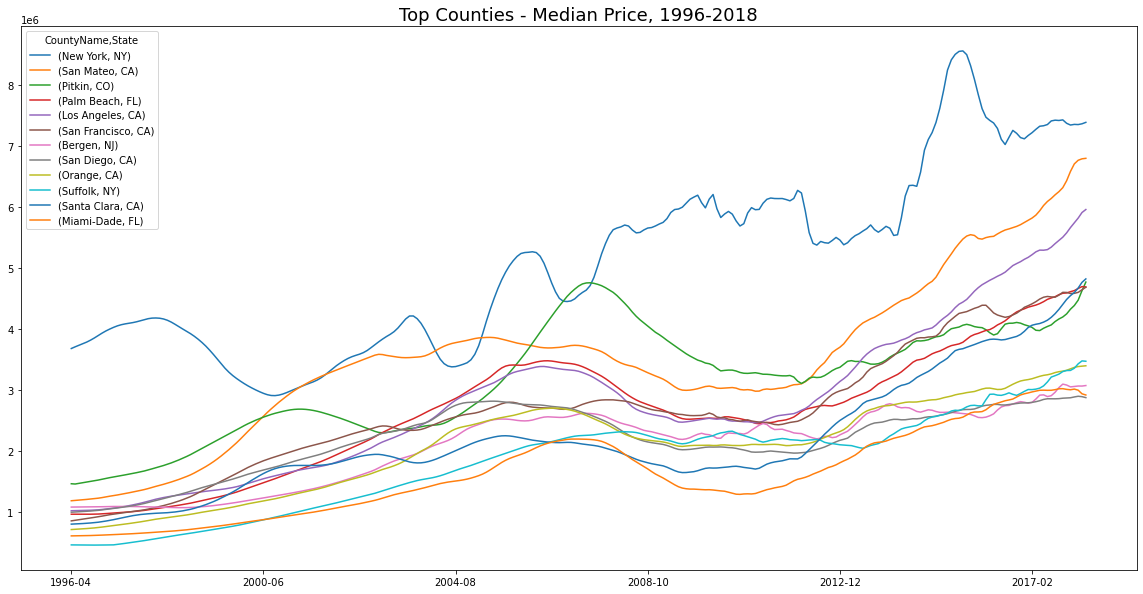

In [13]:
# List of Top Counties
county_list = list(set(list(med_county['CountyName'] + ',' + med_county['State']) + list(avg_county['CountyName'] + \
                ',' + avg_county['State']) + list(std_county['CountyName'] + ',' + std_county['State'])))

# Filtering for Top Counties and removing columns that we don't need
df = data
df['County, State'] = data['CountyName'] + ',' + data['State']
df = df[df['County, State'].isin(county_list) ==  True]
df = df.loc[:, ~df.columns.isin(['RegionID', 'RegionName', 'SizeRank', 'Metro'])]

# Ordering before reshaping
county_group = df.groupby(['CountyName', 'State']).max('median').sort_values(by = 'median', ascending = False)

# Reshaping for Plotting the Time Series
county_long = county_group.T.iloc[:-3]

# Plotting the graph - Top Counties - Median Price, 1996-2018
county_long.plot(figsize=(20,10))
plt.title('Top Counties - Median Price, 1996-2018', fontsize = 18);

In [14]:
# Country-state list
county_state_list = set(list(df['City'] + ', ' + df['State']))

# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")

# Creating a dictionary to parse latitude and longitude
dict_val = {}
for val in list(county_state_list):
    try:
        location = geolocator.geocode(val)
        dict_val[val] = (location.latitude, location.longitude)
    except Exception:
        continue

# Removing bogus entries
del dict_val['Placentia, CA']
del dict_val['Silverado, CA']
del dict_val['Half Moon Bay, CA']


In [15]:
# United States Map
m = folium.Map(location=[39, -95], zoom_start = 4, width = 800, height = 500)

# Marking our top locations on the US map
for key, val in dict_val.items():
    folium.Marker([dict_val[key][0], dict_val[key][1]], popup=key).add_to(m)

### Top Locations: US Map
Bringing more color to our intuition, next I plot the cities that are comprised within our top counties onto the US map. Using a latitude and longitude geolocator, we're able to match these information to their respective location on the map. Unfortunately, 3 entries didn't have a perfect match and were excluded from the sample. Even though suboptimal, this doesn't change the overall analytical effect. The removed areas are all from California, specifically: Half Moon Bay, Placentia and Silverado.

To wit, I combine all the top 10 entries from the median, mean and standard-deviation DataFrames above. From eyeballing the markers below, we can see the over-representativeness of California, Florida and NY/NJ.

In [16]:
# Plotting our US map
m

## Time Series Analysis
The next step of this exercise is delve deeper into the time series analysis, modeling and forecasting workflow. For the next steps, I decided to work on the DataFrame with County averages. There is no loss in the analysis or generality of the results if the decision was to use the County median DataFrame. With that in mind, first I plot side-by-side mean, the rolling mean and rolling standard-deviation of each county. For the rolling statistics, these are estimated using a 12-period window.

In [17]:
# Preparing the DataFrame for rolling statistics
county_rol = df.groupby('County, State').max('average').sort_values(by = 'average', ascending = False)

# Reshaping the Time Series
county_rol_long = county_rol.T.iloc[:-3]

# County List Rolling Statistics calculation
stat_dict = {}
for county in county_list:
    # The first value of each key is the mean (index 0), the second is the rolling mean (index 1),
    # the third is the rolling std deviation (index 2). The rolling stats use a 12-month window
    stat_dict[county] = (county_rol_long[county], county_rol_long[county].rolling(window = 12, center = False).mean(),\
                         county_rol_long[county].rolling(window = 12, center = False).std()) 


### Mean, Rolling Mean and Rolling Standard-Deviation
Visually inspecting all of the counties, it becomes clearer the effect of the mortgage crises over prices. With the exception of New York, all areas suffered a dip to their mean prices. After that period, we see a recovery of these series. Surprisingly, there isn't much variation to the standard-deviation estimates, with the exception of New York, across the board.

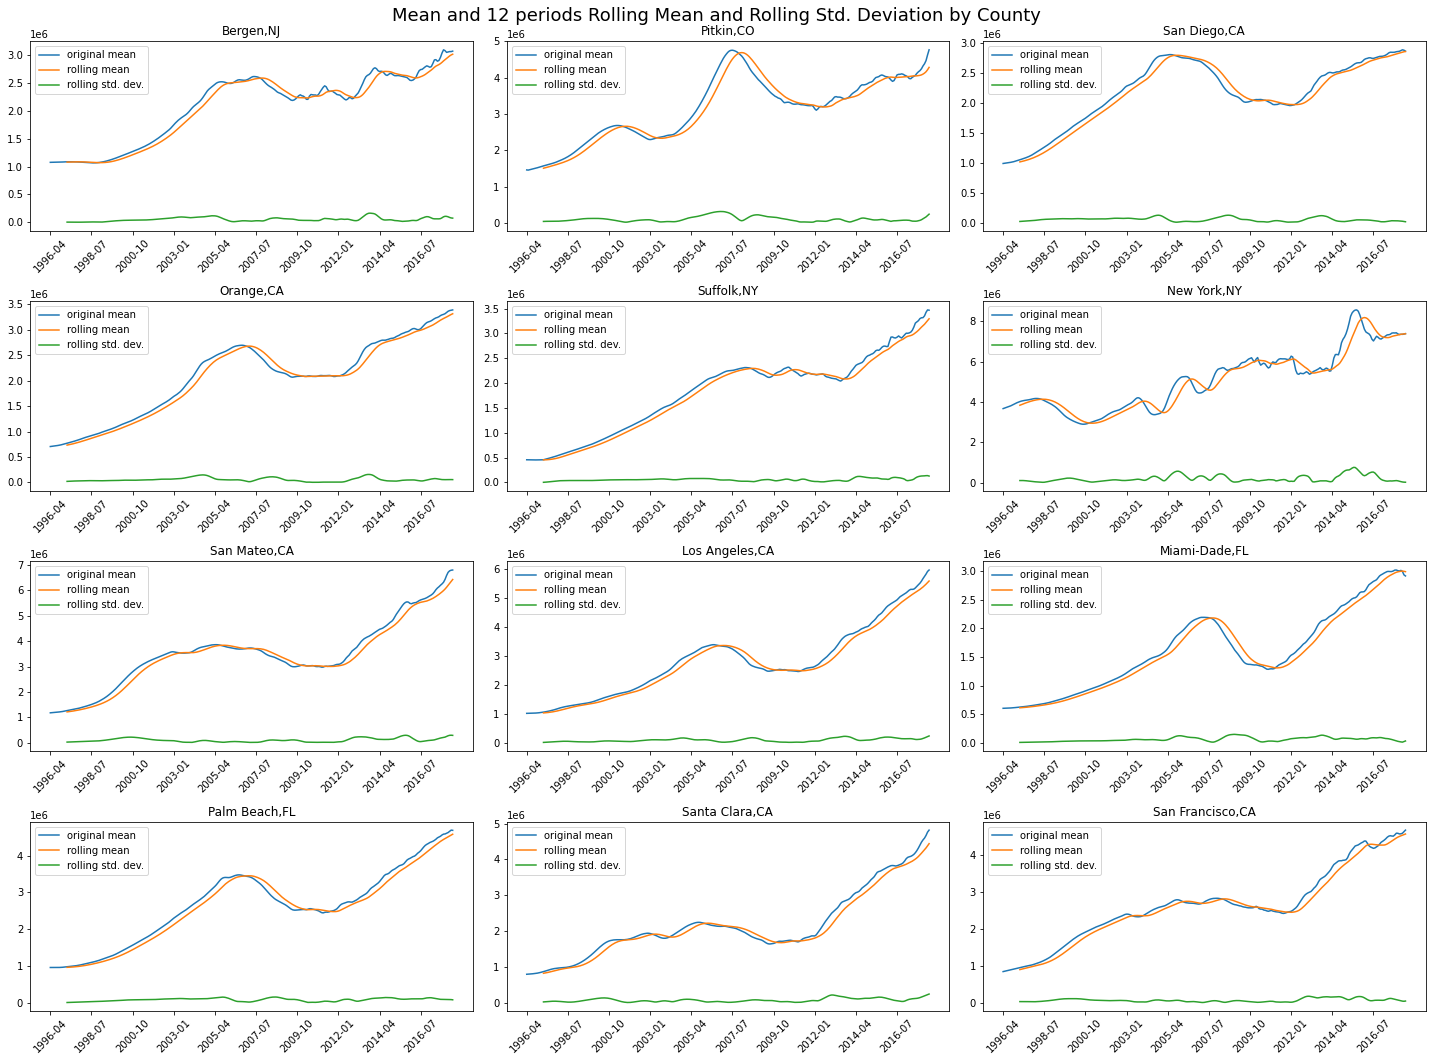

In [18]:
# Plotting rolling stats by county
fig, ax = plt.subplots(4,3, figsize = (20,15))
for count, val in enumerate(stat_dict):
    ax[count // 3][count % 3].plot(stat_dict[val][0], label = 'original mean')
    ax[count // 3][count % 3].plot(stat_dict[val][1], label = 'rolling mean')
    ax[count // 3][count % 3].plot(stat_dict[val][2], label = 'rolling std. dev.')
    ax[count // 3][count % 3].set_title(val)
    ax[count // 3][count % 3].legend()
    ax[count // 3][count % 3].set_xticks(county_rol_long.reset_index()['index'])
    ax[count // 3][count % 3].set_xticklabels(county_rol_long.reset_index()['index'], rotation = 45)
    ax[count // 3][count % 3].locator_params(axis="x", nbins=10, tight = True)
    fig.suptitle('Mean and 12 periods Rolling Mean and Rolling Std. Deviation by County', fontsize = 18)
    plt.tight_layout();

### Log Returns: Mean, Rolling Mean and Standard-Deviation
Even though information, from an investor standpoint, looking at mean prices won't provide compelling evidence. To create a consistent investment thesis, returns are better suited. For this next step, I calculate the natural logarithm of returns, their 12-period rolling mean and standard deviation. 

The calculation of log returns is better-suited than regular calculation of returns - since it 'flattens' the series. From a time series perspective, we can see how these log returns and other statistics go up and down around 0. There is considerable variation, with peaks and drops. Noticeably, New York has a distinct pattern in comparison with the other locations.

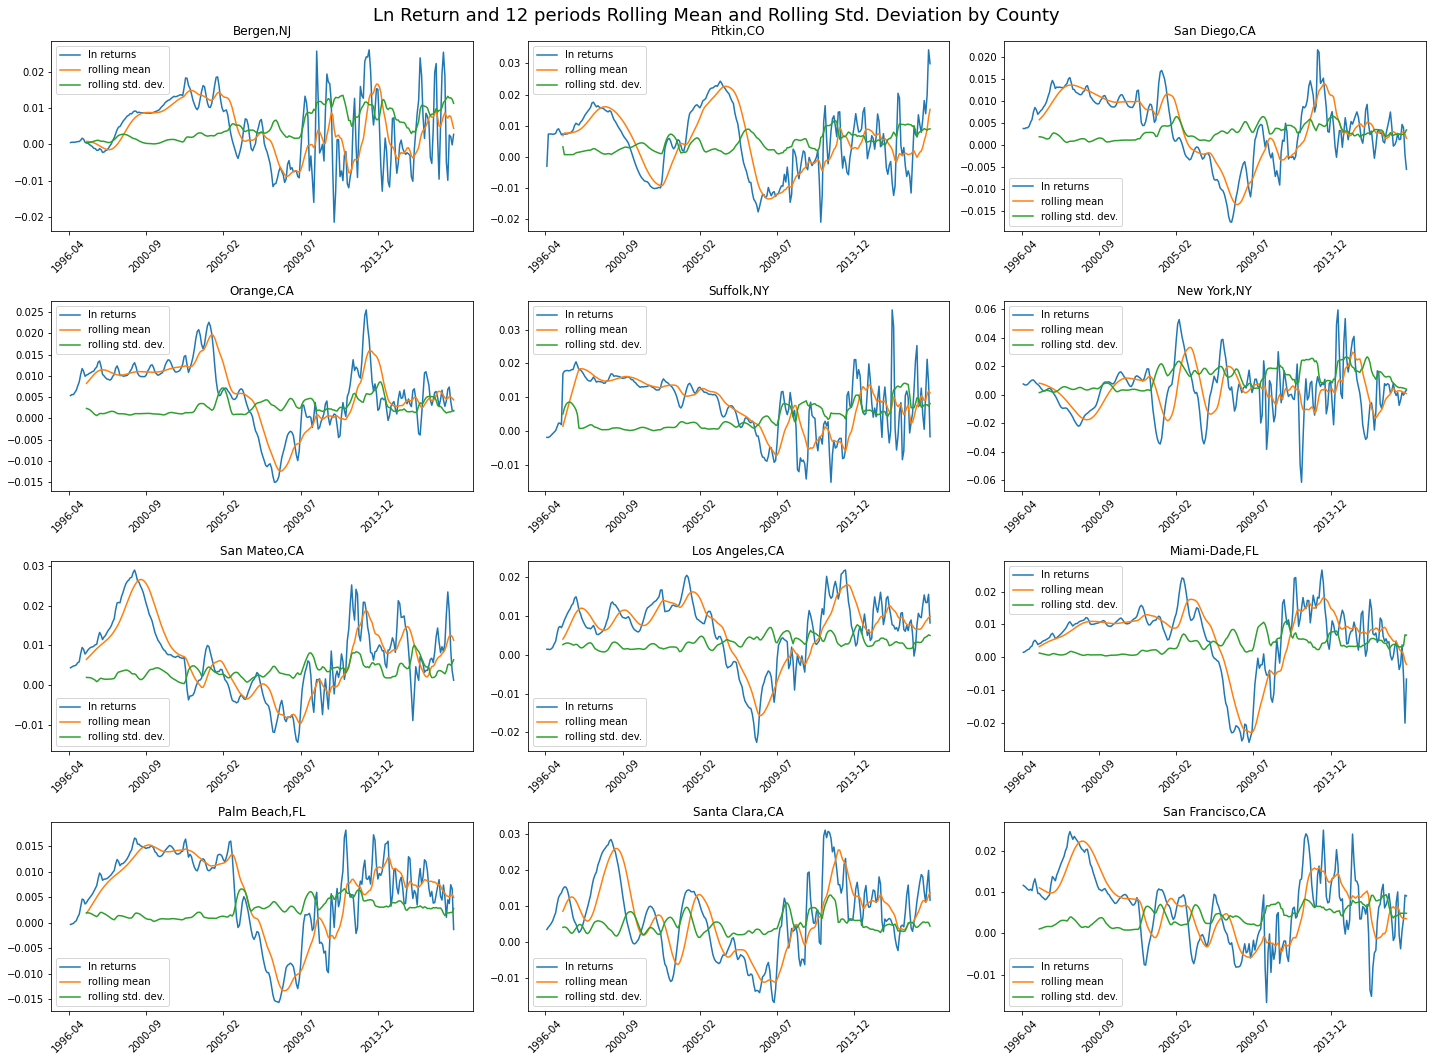

In [19]:
# Creating a dict of returns, I'll generate specific DataFrames to isolate each county
ret_dict = {}
for county in county_list:
    # The first value is the ln return (index 0), the second is the rolling 12-month average (index 1),
    # the third one is the 12-month std. deviation (index 2)
    aux_df = pd.DataFrame(county_rol_long[county])
    aux_df['shift'] = county_rol_long[county].shift(1)
    aux_df['ln ret'] = np.log(aux_df[county] / aux_df['shift'] )
    ret_dict[county] = (aux_df['ln ret'], aux_df['ln ret'].rolling(window = 12, center = False).mean(), \
                        aux_df['ln ret'].rolling(window = 12, center = False).std())

# Plotting the returns on a Graph
fig, ax = plt.subplots(4,3, figsize = (20,15))
for count, val in enumerate(ret_dict):
    ax[count // 3][count % 3].plot(ret_dict[val][0], label = 'ln returns')
    ax[count // 3][count % 3].plot(ret_dict[val][1], label = 'rolling mean')
    ax[count // 3][count % 3].plot(ret_dict[val][2], label = 'rolling std. dev.')
    ax[count // 3][count % 3].set_title(val)
    ax[count // 3][count % 3].legend()
    ax[count // 3][count % 3].set_xticks(aux_df.reset_index()['index'])
    ax[count // 3][count % 3].set_xticklabels(aux_df.reset_index()['index'], rotation = 45)
    ax[count // 3][count % 3].locator_params(axis="x", nbins=5, tight = True)
    fig.suptitle('Ln Return and 12 periods Rolling Mean and Rolling Std. Deviation by County', fontsize = 18)
    plt.tight_layout();


### Risk-weighted returns
But how to properly compare returns? Just stacking them up doesn't tell much, since it doesn't consider the risk of each investment. Since our company is interested about the 'best bang for the buck', I then propose a metric of risk-weighted return.

From Finance, the standard-deviation of returns is a metric of not only its variability but also a risk measure. So, by scaling returns by its standard-deviation, we have a way of unitizing returns. As such, we have a risk-weighted measure. After the calculation of this metric, we rank up once again the counties being studied.

In such fashion, we can provide a more educated perspective about which counties such be prioritized into our modeling framework.

In [20]:
# Calculating risk-weighted return. First entry is the risk weighted return
wtd_ret = {}
for county in county_list:
    aux_df = pd.DataFrame(county_rol_long[county])
    aux_df['shift'] = county_rol_long[county].shift(1)
    aux_df['ln ret'] = np.log(aux_df[county] / aux_df['shift'] )
    aux_df['risk wtd'] = aux_df['ln ret'].rolling(12).mean() / aux_df['ln ret'].rolling(12).std()
    wtd_ret[county] = aux_df['risk wtd']

In [21]:
# Wtd Return DataFrame
df_wtd = pd.DataFrame.from_dict(wtd_ret).dropna()

# Historical Risk Adj. Return
hist_ret_wtd = df_wtd.mean(axis = 0).sort_values(ascending = True)

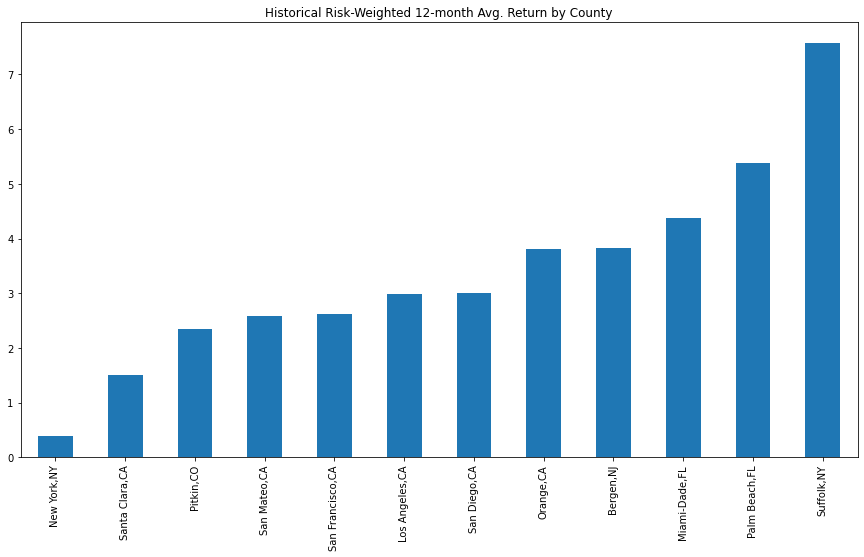

In [22]:
# Risk-Wtd Return
hist_ret_wtd.plot.bar(figsize = (15, 8))
plt.title('Historical Risk-Weighted 12-month Avg. Return by County');

From the figure above, we can see that even knowing that New York has the most expensive properties, when we scale it by its standard-deviation, the unitized return metric is the least profitable one. Surprisingly, the top three counties where the risk-weighted return is the most significant are: Suffolk, NY; Palm Beach, FL and Miami-Dade, FL.

Interestingly as well, even though we saw a lot of Californian counties scoring as the highest median and mean prices, their risk-weighted returns aren't the most profitable. As such, to pursue our modeling framework and providing our stakeholders the proper assessment, we will select the top three counties to forecast house prices.

### Testing for Stationarity: the Unit-Root (ADF) Test
The previous inspections made clear that series are far from being stationary. One way of asessing it properly is running the ADF test and find how many differences are needed to sweep out non-stationarity concerns. Below I provide an automated test that will run it several times until the p-value falls below the 5% threshold. It is worth remembering that the null hypothesis of the ADF test states that series are not stationary. 

The results of our test shows that for Suffolk, NY 2 differences will make the series stationary. For Palm Beach, 3 differences and for Miami-Dade - both in FL - 1 difference suffices. With this information, we'll get to the next step of our time serires workflow: the SARIMAX modeling.

But first, I separate these county-state regions into three DataFrames.

In [23]:
# Working with the top three counties - Unit-Root test
for p in ['Suffolk,NY', 'Palm Beach,FL', 'Miami-Dade,FL']:
    # Checking for the mean prices - using the same dict as before
    df_test = pd.DataFrame(stat_dict[p][1]).dropna()
    adftest = adfuller(df_test)
    count = 0
    print(p + ' ADF test:')
    print('======================')
    if adftest[1] >= 0.05:
        while adftest[1] >= 0.05:
            print(count, 'Difference(s).')
            print('p-value: ', round(adftest[1],4))
            print('-Fail to reject H0.\n')
            df_test = df_test.diff().dropna()
            adftest = adfuller(df_test)
            count +=1
        else:
            print(count, 'Difference(s)')
            print('-H0 is rejected.\n')

Suffolk,NY ADF test:
0 Difference(s).
p-value:  0.9146
-Fail to reject H0.

1 Difference(s).
p-value:  0.2779
-Fail to reject H0.

2 Difference(s)
-H0 is rejected.

Palm Beach,FL ADF test:
0 Difference(s).
p-value:  0.6805
-Fail to reject H0.

1 Difference(s).
p-value:  0.171
-Fail to reject H0.

2 Difference(s).
p-value:  0.2096
-Fail to reject H0.

3 Difference(s)
-H0 is rejected.

Miami-Dade,FL ADF test:
0 Difference(s).
p-value:  0.708
-Fail to reject H0.

1 Difference(s)
-H0 is rejected.



In [24]:
# Preparing the DataFrames for the SARIMA models: Suffolk, Palm Beach and Miami-Dade
suffolk = flat_df(data, 'Suffolk', 'NY', ('CountyName', 'State'), data_col)

# Palm Beach
pbeach = flat_df(data, 'Palm Beach', 'FL', ('CountyName', 'State'), data_col)

# Miami-Dade
miami = flat_df(data, 'Miami-Dade', 'FL', ('CountyName', 'State'), data_col)

### Seasonal Decomposition
Recall, our dataset has a monthly frequency. It is safe to say that seasonality is a factor that affects real estate prices. Anecdotal evidence and common knowledge argues that are 'hot' markets, such as the spring one. To circumvent such issues, I provide an iterative process below that will try to find the combination of Autoregressive, Integration and Moving Average factors and seasonal order ones.

Since this process is computationally intensive, I limit this combination to just 2 rounds of factors each. The attentive reader must then question the information above. It is said that some of our Counties may exhibit non-stationarity beyond 1 difference. While this is true, incorporating higher degrees into this seasonal decomposition increases time considerably. By changing the inputs of our `seas_dec` function one can estimate other degrees, if wanted.

To choose among combinations, I rank results by their Akaike Information Criterion (AIC). In simple terms, AIC informs how much information is lost from a given run. So, by ranking AICs by ascending order, we can get a grasp of which models performs the model.

Moving to the output of this step, we can see the optimal combinations for each of our selected DataFrames are:
<ul>
    <li><ul><b>Suffolk, NY</b>
    <li>1 round: order = (1, 1, 1), seasonal_order = (1, 1, 1, 12);</li>
    <li>2 rounds: order = (1, 1, 2), seasonal_order = (2, 2, 2, 12);</li>
        </ul></li>
    <li><ul><b>Palm Beach, FL</b>
        <li>1 round: order = (1, 1, 1), seasonal_order = (0, 1, 1, 12);</li>
        <li>2 rounds: order = (1, 2, 2), seasonal_order = (1, 2, 2, 12);</li>
        </ul></li>
    <li><ul><b>Miami-Dade, FL</b>
        <li>1 round: order = (1, 1, 1), seasonal_order = (1, 1, 1, 12);</li>
        <li>2 rounds: order = (0, 2, 2), seasonal_order = (1, 2, 2, 12).</li>
        </ul></li>
</ul>

We will use that information as inputs to our SARIMAX models.

In [25]:
# Seasonal Decomposition and ARIMA factors check - Suffolk
# This might take some time to run, be patient!
pdq_pdqs_1 = seas_dec(suffolk) # (1,1,1) x (1, 1, 1, 12) or (1, 1, 2) x (2, 2, 2, 12)


/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

The combination of (1, 1, 2)x(2, 2, 2, 12) yields the AIC of 2683.4078


In [26]:
# Seasonal Decomposition and ARIMA factors check - Palm Beach
# This might take some time to run, be patient!
pdq_pdqs_2 = seas_dec(pbeach) # (1,1,1) x (0,1,1,12) or (1, 2, 2)x(1, 2, 2, 12)

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

The combination of (1, 2, 2)x(1, 2, 2, 12) yields the AIC of 2308.7179


In [27]:
# Seasonal Decomposition and ARIMA factors check - Miami-Dade
# This might take some time to run, be patient!
pdq_pdqs_3 = seas_dec(miami) # (1, 1, 1) x (1, 1, 1, 12) or (0, 2, 2) x (1, 2, 2, 12)

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

The combination of (0, 2, 2)x(1, 2, 2, 12) yields the AIC of 2486.434


### The Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots
Another way of assessing the Autoregressive and Moving Average behavior is through the Partial Autocorrelation (PACF) and Autocorrelation plots (ACF). Starting by the partial autocorrelation plot, spikes outside of the blue zone (i.e. signficance zone) will illustrate the correlation of a given time serie with its lags.

Using the Suffolk data, we can see there's only one lag - which can be modeled through an autoregressive component. With Palm Beach and Miami-Dade, we see a considerable correlation with the first lags that wanes out around the third component. The proper way of modeling those would be incorporating them as autoregressive features into our model.

Turning now to the Autocorrelation (ACF) plot, it indicates how the moving average component should be modeled. It tails off as time passes by but it shows there's a continuum to these series - indicating that they might not be random. 

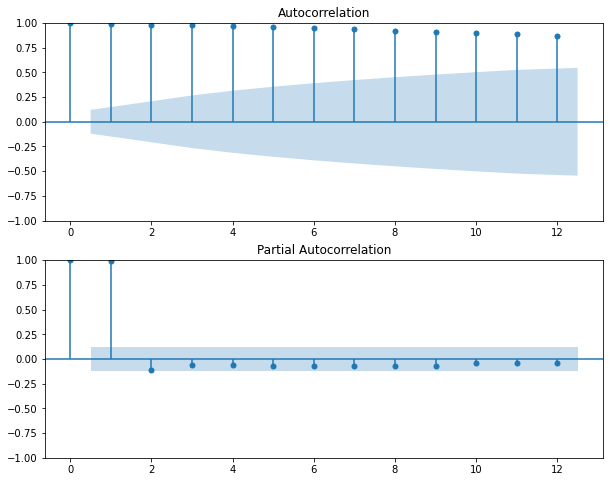

In [28]:
# Suffolk ACF and PCF
func_plot(suffolk)

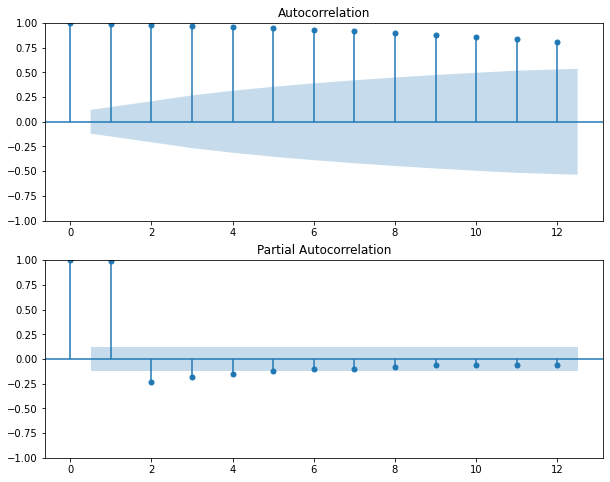

In [29]:
# Palm Beach ACF and PACF
func_plot(pbeach)

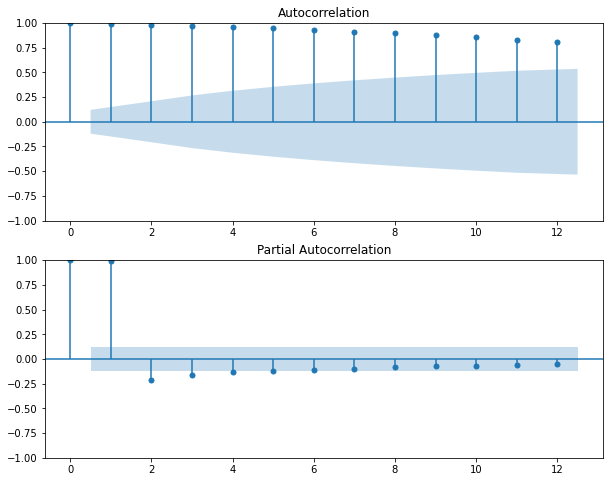

In [30]:
# Miami-Dade ACF and PACF
func_plot(miami)

## Time Series Models and Forecasts
The next step is to gather all the information above and start running and evaluating how our models perform. Remember that the orders (p, d, q) and seasonal parameters (p, d, q, s) were infered from our iterative approach. Using those, I then run the SARIMAX model on training data, plot the diagnostics and calculate the root-mean squared error (RMSE) to evaluate the performance of the models.

### Suffolk, NY (pdq = 1, 1, 2; pdqs = 2, 2, 2, 12)
Running the model on training data (199 observations) with the parameters above, we fail to reject the Ljung-Box statistic - ruling out any concern of non-randomness. The Jarque-Bera statistics rejects the idea of Normal distribution (even though it isn't far off from a 0 skewness and kurtosis 3) - which can be spotted from both the histogram and our quantile plot. It isn't a big concern, but it is always worth taking into consideration. The residuals seem to follow a 'white-noise' pattern, hovering around zero.

The Root-Mean Squared Error (RMSE) is of 2,919.15 meaning that on average or prediction will have a bound of more or less 3,000 dollars when predicting prices. Lastly, the pattern from our prediction exercise using training data seems to be spot on with the actual series.

### Palm Beach, FL (pdq = 1, 2, 2; pdqs = 1, 2, 2, 12)
The estimation on the Palm Beach DataFrame provides a different perspective. The Ljung-Box test has its null rejected - so it seems the data isn't random. This can be spotted through both the Q-Q plot and the residuals. The first shows how data around the edges are not on the line of the empirical quantiles; the latter shows how data doesn't seem to be following a white-noise pattern. The histogram has a asymetric shape.

With respect to the RMSE, the prediction misses the actual values by 1,903.40 and the shape of our prediction seems to exhibit a similar behavior to the acual series.

### Miami-Dade, FL (pdq = 0, 2, 2; pdqs = 1, 2, 2, 12)
The results from our Miami-Dade are similar in characteristics to the ones we obtained from the Suffolk exercise. The residuals seem to follow a white noise pattern, however the Q-Q plot has some deviations at its edges. We fail to reject the Ljung-Box L1 statistics and the Jarque-Bera is rejected - so the data doesn't seem to follow a Normal distribution. This can be eyeballed as well from the histogram of our output.

The RMSE exhibits a deviation of 1743.82 from the actual training data.

Wrapping up this section, we can consider that all models provide a fair estimate of house prices, however the Palm Beach still has some modeling pre-adjustments to be made to have more promising scores when compare to the other two models. Lastly, there is still room for improving Suffolk and Miami-Dade.

So how can investors assess which strategy is the most profitable? That is the subject of the next section.

                                     SARIMAX Results                                      
Dep. Variable:                        Actual Data   No. Observations:                  199
Model:             SARIMAX(1, 1, 2)x(2, 2, 2, 12)   Log Likelihood               -1611.362
Date:                            Tue, 21 Feb 2023   AIC                           3238.725
Time:                                    14:41:28   BIC                           3263.997
Sample:                                04-01-1996   HQIC                          3248.977
                                     - 10-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3548      0.508      0.699      0.485      -0.640       1.350
ma.L1          0.1280      0.485   

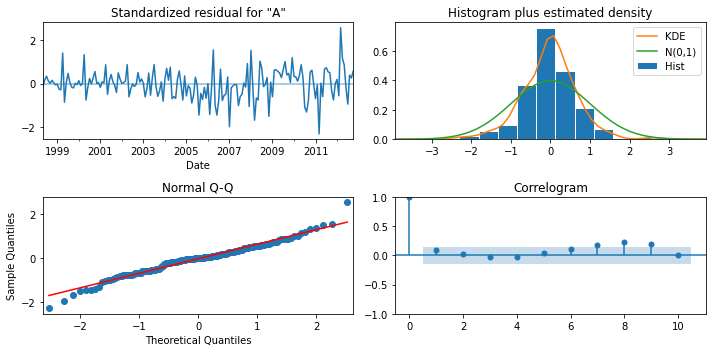

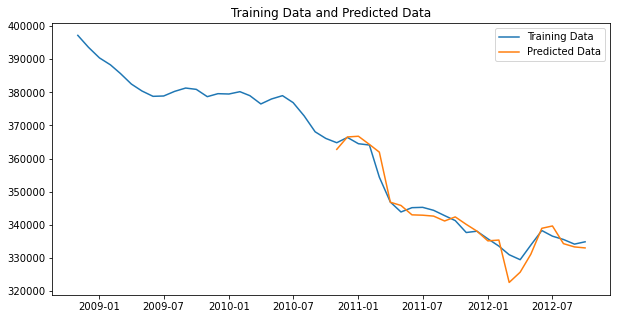

RMSE: 2919.1484


In [32]:
# Suffolk SARIMAX Model with RMSE using training data
rmse_suffolk = rmse_calc(suffolk, (1, 1, 2), (2, 2, 2, 12), 'train')

                                     SARIMAX Results                                      
Dep. Variable:                        Actual Data   No. Observations:                  199
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1449.844
Date:                            Tue, 21 Feb 2023   AIC                           2913.688
Time:                                    14:41:34   BIC                           2935.761
Sample:                                04-01-1996   HQIC                          2922.643
                                     - 10-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7138      0.948      0.753      0.451      -1.143       2.571
ma.L1         -0.6372      0.952   

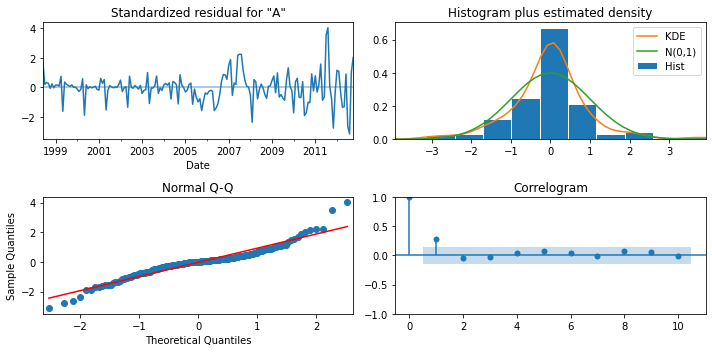

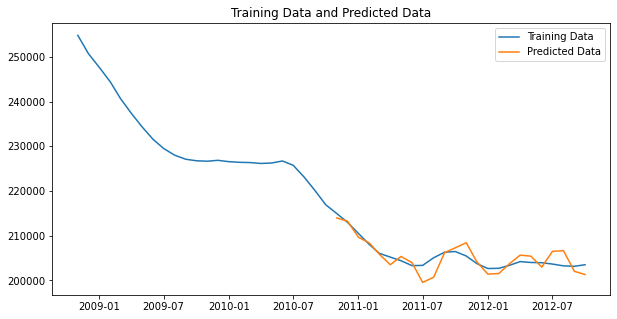

RMSE: 1859.9911


In [33]:
# Palm Beach SARIMAX Model with RMSE using training data
rmse_pb = rmse_calc(pbeach, (1, 2, 2), (1, 2, 2, 12), 'train') 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                        Actual Data   No. Observations:                  199
Model:             SARIMAX(0, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1500.655
Date:                            Tue, 21 Feb 2023   AIC                           3013.310
Time:                                    14:41:40   BIC                           3032.230
Sample:                                04-01-1996   HQIC                          3020.986
                                     - 10-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0446      0.064     -0.692      0.489      -0.171       0.082
ma.L2         -0.0900      0.075   

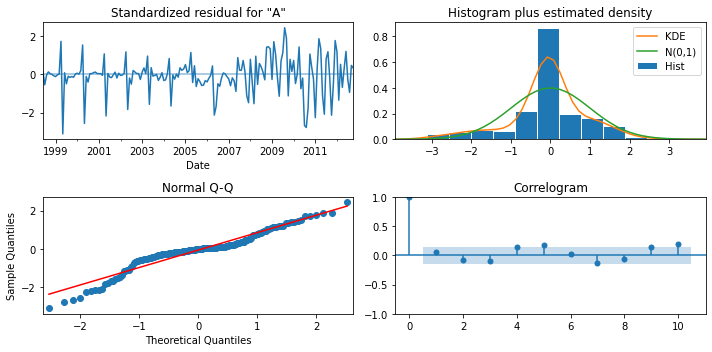

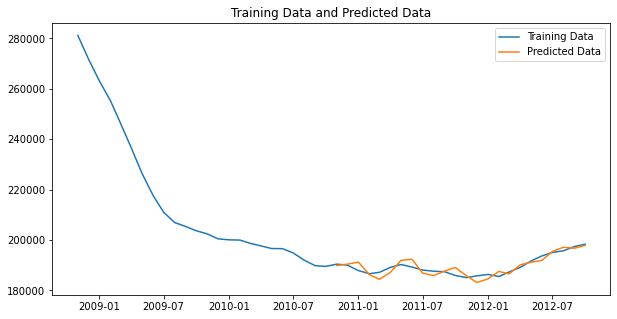

RMSE: 1743.8205


In [34]:
# Miami-Dade SARIMAX Model with RMSE using training data
rmse_md = rmse_calc(miami, (0, 2, 2), (1, 2, 2, 12), 'train')

### Calculating Adjustment Factors
But how can we compare such different models with respect to the most precise investment strategy? I propose an adjustment metric to normalize the root-mean squared error (RMSE) with respect to mean average prices. 

The idea is to understand how far off from average price or which are the bounds that one investor can expect and use that to scale the risk-weighted return. By doing so, if one model is performing better than the other, the latter will penalize the risk-weighted return. Then:

$ Adj. Return = (1 - \frac{RMSE}{Mean Price})\frac{\ln{Return}}{Std.Deviation} $

Since the models seem to be performing pretty well, there is much penalty to our risk-weighted scores. Next, we will forecast values for the upcoming 24-period window.

In [35]:
# Weighted RMSE with respect to mean average prices
# Suffolk RMSE / Mean
wtd_rmse_sf = round(rmse_suffolk / stat_dict['Suffolk,NY'][0].mean(), 6)

# Palm Beach RMSE / Mean
wtd_rmse_pm = round(rmse_pb / stat_dict['Palm Beach,FL'][0].mean(), 6)

# Miami-Dade RMSE / Mean
wtd_rmse_md = round(rmse_md / stat_dict['Miami-Dade,FL'][0].mean(), 6)

print('Suffolk RMSE / Mean Adj. Factor:', wtd_rmse_sf)
print('Palm Beach RMSE / Mean Adj. Factor:', wtd_rmse_pm)
print('Miami-Dade RMSE / Mean Adj. Factor:', wtd_rmse_md)
print('\n')
print('Suffolk Adj. Return:', round((1 - wtd_rmse_sf) * hist_ret_wtd['Suffolk,NY'], 4))
print('Palm Beach Adj. Return:', round((1 - wtd_rmse_pm) * hist_ret_wtd['Palm Beach,FL'], 4))
print('Miami-Dade Adj. Return:', round((1 - wtd_rmse_md) * hist_ret_wtd['Miami-Dade,FL'], 4))

Suffolk RMSE / Mean Adj. Factor: 0.001608
Palm Beach RMSE / Mean Adj. Factor: 0.000706
Miami-Dade RMSE / Mean Adj. Factor: 0.001082


Suffolk Adj. Return: 7.5599
Palm Beach Adj. Return: 5.3811
Miami-Dade Adj. Return: 4.3695


## Appendix: evaluating the model performance on test data
I also provide the example also on testing data. The model seems to perform even better. Please find the outputs below. Across all of the runs, we fail to reject the null on both the Ljung-Box and Jarque-Bera statistics.

All of the predicted models use the combination of orders and seasonal orders estimated through our iterative model above.

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                        Actual Data   No. Observations:                   66
Model:             SARIMAX(1, 1, 2)x(2, 2, 2, 12)   Log Likelihood                -392.815
Date:                            Tue, 21 Feb 2023   AIC                            801.630
Time:                                    14:41:43   BIC                            815.339
Sample:                                11-01-2012   HQIC                           806.622
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3642      4.589      0.079      0.937      -8.629       9.357
ma.L1         -0.3409      4.545   

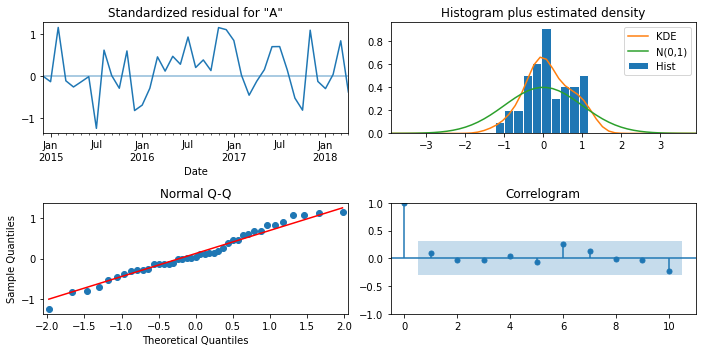

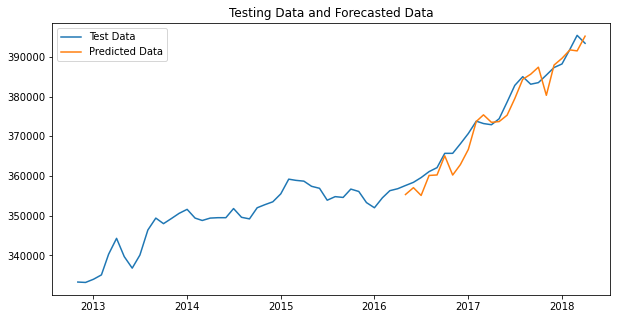

RMSE: 2898.6296


In [36]:
# Running the model on testing data - Suffolk
rmse_suffolk_test = rmse_calc(suffolk, (1, 1, 2), (2, 2, 2, 12), 'test')

                                     SARIMAX Results                                      
Dep. Variable:                        Actual Data   No. Observations:                   66
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood                -342.398
Date:                            Tue, 21 Feb 2023   AIC                            698.797
Time:                                    14:41:46   BIC                            710.619
Sample:                                11-01-2012   HQIC                           703.071
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5554      1.021     -0.544      0.587      -2.557       1.446
ma.L1          0.5117      1.036   

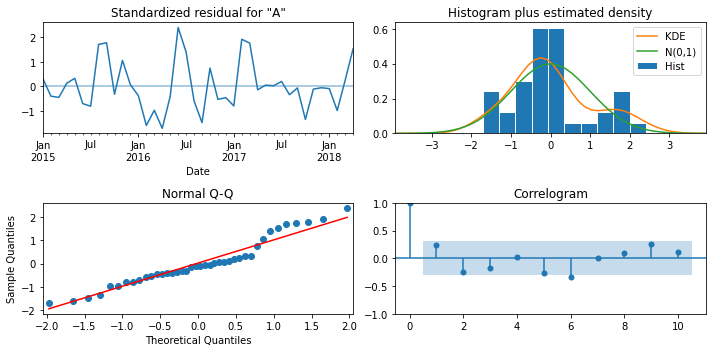

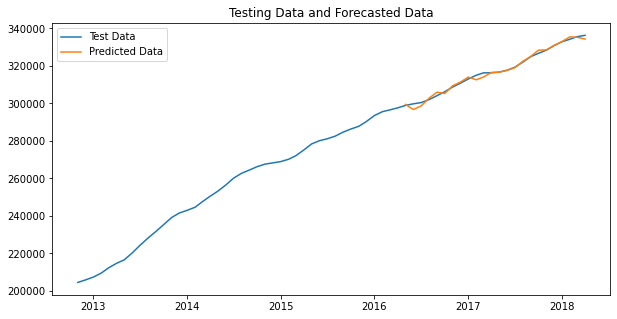

RMSE: 1272.3385


In [37]:
# Running the model on testing data - Palm Beach
rmse_pbeach_test = rmse_calc(pbeach, (1, 2, 2), (1, 2, 2, 12), 'test') 

                                     SARIMAX Results                                      
Dep. Variable:                        Actual Data   No. Observations:                   66
Model:             SARIMAX(0, 2, 2)x(1, 2, 2, 12)   Log Likelihood                -361.581
Date:                            Tue, 21 Feb 2023   AIC                            735.162
Time:                                    14:41:49   BIC                            745.295
Sample:                                11-01-2012   HQIC                           738.826
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0529      0.293     -0.181      0.856      -0.627       0.521
ma.L2         -0.0698      0.078   

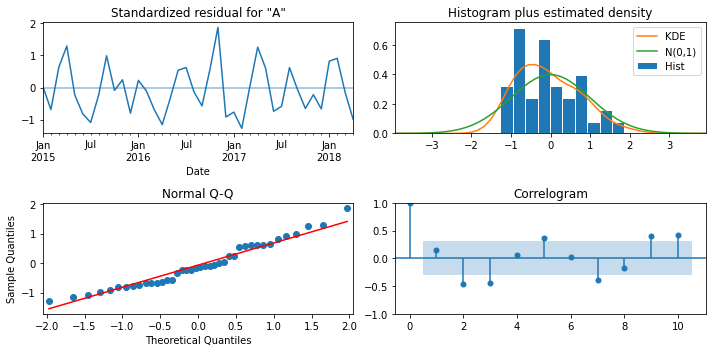

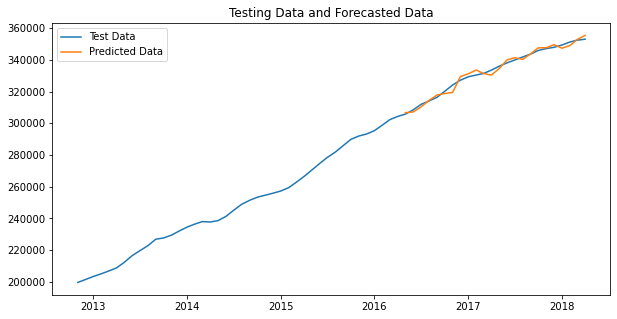

RMSE: 1948.1254


In [38]:
# Running the model on testing data - Miami-Dade
rmse_md_test = rmse_calc(miami, (0, 2, 2), (1, 2, 2, 12), 'test')

### The final step: forecasting
Wrapping up our time series analysis, I provide three examples of 24-month window forecasts using our counties above. Irrespective of their behavior - which are quite similar - the forecasted values continue on a growing trend of prices.

Looking specifically at the Suffolk, NY DataFrame, I provide a longer-term forecast with confidence intervals (10-90%). The long-term forecast considers a 60-month time window, and it is clear as time goes by the predicted values get a larger range. Thus, one can conclude the shorter the investment horizon, the more accurate the house price prediction.

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


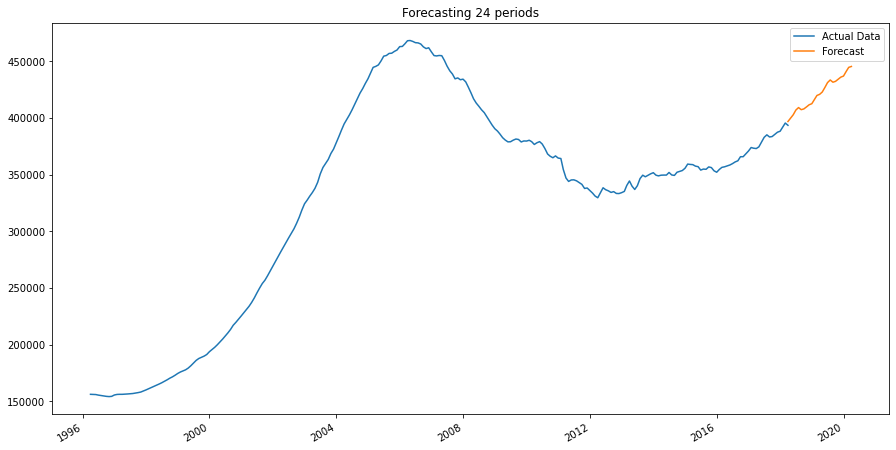

In [41]:
# Forecasting Suffolk, 24-month window
forecast_func(suffolk, (1, 1, 2), (2, 2, 2, 12))

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


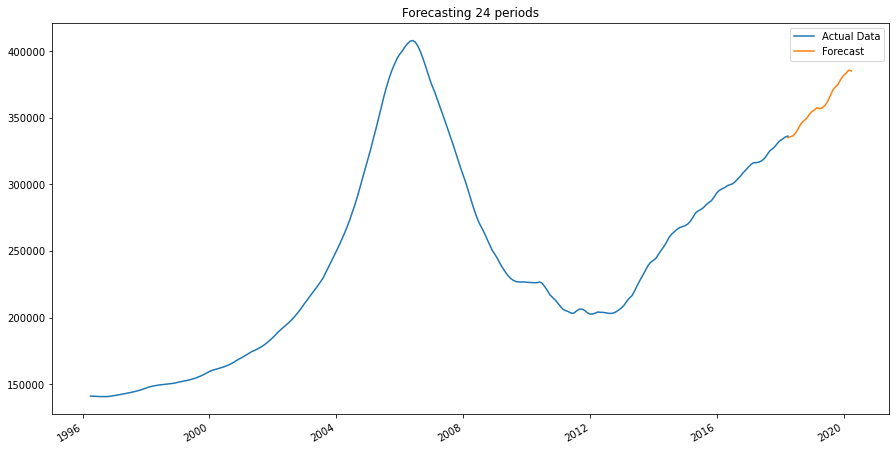

In [42]:
# Forecasting Palm Beach, 24-month window
forecast_func(pbeach, (1, 2, 2), (1, 2, 2, 12)) 

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


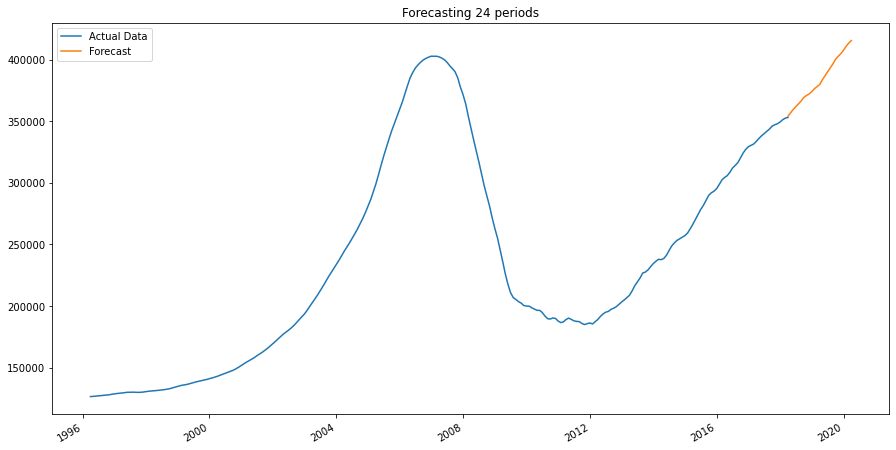

In [43]:
# Forecasting Miami-Dade, 24-month window
forecast_func(miami, (0, 2, 2), (1, 2, 2, 12))

In [ ]:
# Forecasting Suffolk, 60-month window
forecast_ci(suffolk, (1, 1, 2), (2, 2, 2, 12))

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Conclusion
In this project, Goodeye Investments (hypothetical investment firm) is seeking a good bang for the buck with respect to house prices. Using a dataset from Zillow, ranging from 1996 to 2018, I develop a time series model to predict house prices.

The steps pursued are: exploratory data and time series analysis, ranking which counties are the most valuable with respect to their median and mean and assessing how they fare with respect to risk (i.e. standard deviation). From this initial filtering, we end up with 3 counties: Suffolk, NY; Palm Beach, FL and Miami-Dade, FL.

Using a time series framework and SARIMAX models, I end up with a model to predict mean house prices. Under a confidence interval approach, I argue that under an investment horizon of 24 months the model can predict fairly reasonable the prices within these counties. However, as time goes by, the estimates have an ample range and are less accurate.

### Takeaways
The best historical risk-weighted return is located in Suffolk, NY, followed by Palm Beach, FL and Miami-Dade, FL. So the firm can pursue two distinct strategies:
<ul><li><b>Divide and Conquer</b> - investing in real estate into the best bang for the buck county/location all at once;</li>
<b><li>Rays of the Sun</b> - choosing one specific location and irradiating the strategy within an unique county;</li>
<b><li>Alternative analysis</b> - the firm may consider using the same framework for a safer bet - that is, investing in more established counties. However, that might pose another layer of risk, competition.</li></ul>

### Further improvements and limitations
Thinking about the portfolio theory, one could implement an optimization model to assess what would be the best combination (i.e. efficient frontier) to invest in real estate.

The dataset doesn't incorporate other exogenous features that can be related with house prices and these can be helpful to model the outcomes. Furthermore, one could include geographical and socio-economical data with respect to these locations to further increase the accuracy and robustness of models.

Lastly, I don't delve deeper into each of these locations. There is considerable variation within counties and one interesting exercise would be pointing out underpriced and overpriced locations at a more granular level.
